# 2CS SIQ2-SIL2 TP06. Machines à vecteurs de support (SVM) et optimisation stochastique

Dans ce TP, nous allons traiter les SVMs.
Premierement, nous allons implémenter les deux formalismes de SVM : primal et dual.
Ensuite, nous allons tester l'effet des hyper-paramètres de SVM.
Aussi, nous allons voir l'intérêt de l'optimisation stochastique.

- **Binôme 01** : BELBACHIR RYAN
- **Groupe** : SIL2

In [1]:
import matplotlib
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.23.4', '1.5.1', '3.6.2')

In [2]:
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

## INTRODUCTION 

Concernant la régression logistique binaire, une classe a la valeur $1$ (appartient à la classe) ou $0$ (n'appartient pas à la classe). 
Pour SVM, une classe a la valeur $1$ (appartient à la classe positive) ou $-1$ (appartient à la classe négative).
Dans ce cas, $0$ veut dire l'échantillons est dans la marge.

## I. Réalisation des algorithmes

Dans cette partie, nous allons implémenter les deux formes des SVMs : primal et dual.
Pour "type hinting", nous avons utilisé les chaînes de caractères afin de préciser la dimension et le type des éléments des tableaux numpy.
Dans ce cas, le hint est écrit comme : "np.ndarray(Dimensions)[type]".

### I.1. SVM Linéaire (Primal)

Ici, nous allons essayer d'implémenter la forme primal des SVMs pour la classification binaire. 
C'est la forme similaire à celle de la régression logistique. 

#### I.1.1. Prédiction 

Pour prédire le résultat, nous utilisons une fonction $signe$ sur la combinaison linéaire des attributs. 

$$signe(z) = \begin{cases}
1 & \text{si } z \ge 0 \\
0 & \text{sinon }
\end{cases}$$

In [3]:
def zf(X    : 'np.ndarray(M, N)[float]', 
      Theta: 'np.ndarray(N)[float]'   ) -> 'np.ndarray(M)[float]':
    return np.dot(X, Theta)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([-1.5,  0. ,  1.5])
#---------------------------------------------------------------------

X_t     = np.array([[2. , -10. ], 
                    [1. , - 2. ], 
                    [1.5,   3. ]])
Theta_t = np.array([ 0.5,   0.25])
Z       = zf(X_t, Theta_t)
Z

array([-1.5,  0. ,  1.5])

In [4]:
# TODO: Estimation SVM (primal)
def signe(Z: 'np.ndarray(M)[float]') -> 'np.ndarray(M)[int]':
    return np.where(Z>=0,1,0)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([0, 1, 1])
#---------------------------------------------------------------------

signe(Z)

array([0, 1, 1])

#### I.1.2. Fonction du coût

Selon la fonction d'erreur, nous pouvons définir une marge forte (hard margin) ou une marge faible (soft margin).
Dans notre cas, nous allons implémenter la deuxième puisque la plupart des problèmes ne sont pas vraiment séparables (il existe des chauveuchements entre les classes).
Nous allons implémenter la fonction du coût appelée **Hinge** dont la formule est la suivante :
$$ J = \frac{C}{2M} \sum\limits_{i=0}^{M} \max(0, 1- y^{(i)} z^{(i)})$$
Où :
- $M$ nombre des échantillons et $N$ nombre des attributs
- $(i)$ veut dire le ième échantillon
- $\theta_j$ est le paramètre de l'attribut $j$ (peu-être référencé par $w_j$ dans d'autres ouvrages)
- $z^{(i)} = \theta_0 + \sum_{j=1}^{N} \theta_j x_j^{(i)}$
- $C$ est un paramètre avec deux objectifs différents: maximiser la marge et minimiser le nombre d'erreurs sur les données d'entraînement. En modifiant le paramètre C, nous pouvons choisir de privilégier un objectif sur un autre.


In [5]:
# TODO: Coût SVM (primal)
def J_hinge(Z    : 'np.ndarray(M)[float]', 
            Y    : 'np.ndarray(M)[float]', 
            Theta: 'np.ndarray(N)[float]', 
            C    : 'float' = 1.) -> 'float':
    M=len(Z)
    i=0
    summ=0
    while i<M :
        maxVal = max(0,1-Y[i]*Z[i])
        summ+=maxVal
        i+=1
    return (C/(2*M))*summ

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# 0.3333333333333333
#---------------------------------------------------------------------

Z_t = np.array([-1.5,  0.,  1.5])
Y_t = np.array([ 0. ,  1.,  1. ])

J_hinge(Z_t, Y_t, Theta_t, C=1.)

0.3333333333333333

#### I.1.3. Fonction des gradients

Le gradient de la fonction **Hinge** est calculé comme suit :
$$ \frac{\partial J}{\partial \theta_j} = 
\frac{1}{M} \sum\limits_{i=1}^M \begin{cases}
0 & \text{si } y^{(i)} z^{(i)} \ge 1\\
- C x^{(i)}_j y^{(i)} & \text{sinon}  \\
\end{cases}$$
Où :
- $M$ nombre des échantillons et $N$ nombre des attributs
- $(i)$ veut dire le ième échantillon
- $\theta_j$ est le paramètre de l'attribut $j$ (peu-être référencé par $w_j$ dans d'autres ouvrages)
- $z^{(i)} = \theta_0 + \sum_{j=1}^{N} \theta_j x_j^{(i)}$
- $C$ est un paramètre

**HINT**
```
# A[M]  => A.reshape(-1, 1) = A'[M, 1]
# A[M]  => A[:, np.newaxis] = A'[M, 1]
# A[M, 1] => np.repeat(A, N, axis=1) = A'[M, N] (les colonnes de la même ligne ont la même valeur)
# A[M, N] bool, B[M, N], C[M, N] => np.where(A, B, C) = D[M, N] une matrice avec  des élements de B et de C selon A
```

In [6]:
# TODO: Gradients SVM (primal)
def dJ_hinge(X    : 'np.ndarray(M,N)[float]', 
             Z    : 'np.ndarray(M)[float]'  , 
             Y    : 'np.ndarray(M)[float]'  , 
             Theta: 'np.ndarray(N)[float]'  , 
             C    : 'float' = 1.
            )    -> 'np.ndarray(M)[float]':
    M = len(Z)
    i=0
    summ=0
    j=0
    result = []
    for j,theta in enumerate(Theta):
        summ=0
        i=0
        while i<M:
            if(Y[i]*Z[i]>=1):
                summ+=0
            else:
                summ+=(-C)*X[i][j]*Y[i]
            i+=1
        result.append((1/M)*summ)

    return np.array(result)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([-0.33333333,  0.66666667])
#---------------------------------------------------------------------

X_t = np.array([[2. , -10.], 
                [1. , - 2.], 
                [1.5,   3.]])
Z_t = np.array([-1.5, 0., 1.5])
Y_t = np.array([-1. , 1., 1. ])

dJ_hinge(X_t, Z_t, Y_t, Theta_t)

array([-0.33333333,  0.66666667])

#### I.1.4. Descente des gradients et regroupement des fonctions

**Rien à programmer ici**

Ici, nous avons implémenté trois variantes de la descente du gradient : 
- **GD** : La descente du gradient normale avec les sous-gradients de tous les échantillons. Pour chaque itération, la mise à jours les paramètres est faite en utilisant la moyenne des sous-gradients sur tout le dataset.
- **SGD** : La descente du gradient stochastique. Pour chaque itération, un échantillon (observation) est choisi d'une façon aléatoire. Les paramètres sont mis à jours en se basant seulement sur les gradients de cet échantillon.
- **SGDA** : Une version de la descente du gradient stochastique que nous avons proposé pour comparaison. Pour chaque itération, les paramètres sont mis à jours sur chaque échantillon d'une manière aléatoire. En sortant de la boucle des échantillons, l'erreur de l'itération est calculée sur tous les échantillons après la dernière mise à jour des paramètres.

In [7]:
def J_L2(Theta: 'np.ndarray(N)[float]', M: 'int') -> 'float':
    return np.sum(Theta[1:]**2)/(2*M)

def dJ_L2(Theta: 'np.ndarray(N)[float]', M: 'int') -> 'np.ndarray(N)[float]':
    msk    = np.ones(Theta.shape)
    msk[0] = 0
    return  Theta * msk/M

# Déscente des sous-gradients
def GD_svm(X       : 'np.ndarray(M,N)[float]', 
           Y       : 'np.ndarray(M)[float]'  , 
           Theta   : 'np.ndarray(N)[float]'  , 
           max_iter: int   = 100             , 
           alpha   : float = 0.1             , 
           C       : float = 1.) -> Tuple[List['np.ndarray(N)[float]'], List['float']]: 
    
    couts = []
    M     = len(Y)
    Theta = Theta.copy()
    
    for it in range(max_iter):
        Z      = zf(X, Theta)
        Theta -= alpha * (dJ_L2(Theta, M) + dJ_hinge(X, Z, Y, Theta, C=C))
        couts.append(J_L2(Theta, M) + J_hinge(Z, Y, Theta, C=C))
    
    return Theta, couts

import random

# Déscente stochastique des sous-gradients
def SGD_svm(X      : 'np.ndarray(M,N)[float]', 
           Y       : 'np.ndarray(M)[float]'  , 
           Theta   : 'np.ndarray(N)[float]'  , 
           max_iter: 'int'   = 100           , 
           alpha   : 'float' = 0.1           , 
           C       : 'float' = 1.) -> Tuple[List['np.ndarray(N)[float]'], List['float']]:  

    M     = len(X)
    couts = []
    Theta = Theta.copy()
    
    for it in range(max_iter):
        # Mettre à jours les paramettres sur un seul échantillon choisi aléatoirement
        i      = random.randint(0, M-1) 
        X_i    = np.array([X[i, :]])
        Y_i    = np.array([Y[i]])
        Z_i    = zf(X_i, Theta)
        Theta -= alpha * (dJ_L2(Theta, M) + dJ_hinge(X_i, Z_i, Y_i, Theta, C=C))
        Z      = zf(X, Theta)
        # Ici, on va calculer l'erreur sur tous les échantillons (dataset complet)
        # et pas seulement l'échantillon choisi aléatoirement
        # puisqu'on veut savoir l'erreur globale pour la comparer avec les autres méthodes
        couts.append(J_L2(Theta, M) + J_hinge(Z, Y, Theta, C=C))
    
    return Theta, couts

# Déscente stochastique des sous-gradients pour tous
def SGDA_svm(X       : 'np.ndarray(M,N)[float]', 
             Y       : 'np.ndarray(M)[float]'  , 
             Theta   : 'np.ndarray(N)[float]'  , 
             max_iter: 'int'   = 100           , 
             alpha   : 'float' = 0.1           , 
             C       : 'float' = 1.) -> Tuple[List['np.ndarray(N)[float]'], List['float']]: 
    
    M     = len(X)
    couts = []
    Theta = Theta.copy()
    
    for it in range(max_iter):
        idx = np.random.permutation(M)
        for i in idx: 
            X_i    = np.array([X[i, :]])
            Y_i    = np.array([Y[i]])
            Z_i    = zf(X_i, Theta)
            Theta -= alpha * (dJ_L2(Theta, M) + dJ_hinge(X_i, Z_i, Y_i, Theta, C=C))
        Z  = zf(X, Theta)
        couts.append(J_L2(Theta, M) + J_hinge(Z, Y, Theta, C=C))
    
    return Theta, couts

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([4.66666667, 1.06292621]),
#  array([4.44      , 0.87011866]),
#  array([6.65      , 0.83105557]))
#---------------------------------------------------------------------

X_t = np.array([[0.02, -0.10], 
                [0.01, -0.02], 
                [0.15,  0.03]])
Theta_t = np.array([0., 0.])
Y_t = np.array([-1., 1., 1.])

Theta_t1, couts_t1 = GD_svm  (X_t, Y_t, Theta_t, C=10.)
Theta_t2, couts_t2 = SGD_svm (X_t, Y_t, Theta_t, C=10.)
Theta_t3, couts_t3 = SGDA_svm(X_t, Y_t, Theta_t, C=10.)
Theta_t1, Theta_t2, Theta_t3

(array([4.66666667, 1.06292621]),
 array([5.27      , 1.29804863]),
 array([6.5      , 0.8076942]))

In [8]:
class SVM(object):
    
    def __init__(self, 
                 max_iter: 'int'                 = 100 , 
                 alpha   : 'float'               = 0.1 , 
                 norm    : 'booleen'             = True, 
                 const   : 'booleen'             = True, 
                 C       : 'float'               = 1.  , 
                 solver  : 'string(GD|SGDA|SGD)' = "GD"): 
        
        self.max_iter = max_iter
        self.alpha    = alpha
        self.norm     = norm
        self.const    = const
        self.C        = C
        if   solver == "SGDA":
            self.entrainer_svm = SGDA_svm
        elif solver == "SGD" :
            self.entrainer_svm = SGD_svm
        else                 :
            self.entrainer_svm = GD_svm
                
    
    def entrainer(self, 
                  X: 'np.ndarray(M,N)[float]', 
                  Y: 'np.ndarray(M)[float]') -> 'List[float]':
        YY = np.array(Y)
        #Transformer les Y == 0 vers Y == -1
        YY[YY==0] = -1
        
        XX = np.array(X)
        
        if self.norm :
            self.mean = np.mean(XX, axis=0)
            self.std  = np.std (XX, axis=0)
            XX        = np.where(self.std==0, XX, (XX - self.mean)/self.std)
        if self.const:
            XX        = np.append(np.ones((XX.shape[0],1)), XX ,axis=1)
        
        Theta = np.zeros(XX.shape[1])
        self.Theta, couts = self.entrainer_svm(XX, YY, Theta, max_iter=self.max_iter, alpha=self.alpha, C = self.C)
        return couts
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, 
                X  : 'np.ndarray(M,N)[float]', 
                cls: 'booleen' = True) -> Union['List[float]', 'List[int]']:
        XX = np.array(X)
        if self.norm :
            XX = np.where(self.std==0, XX, (XX - self.mean)/self.std)
        if self.const:
            XX = np.append(np.ones((XX.shape[0],1)), XX ,axis=1)
        Z = zf(XX, self.Theta)
        return Z if not cls else signe(Z)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([1])
#---------------------------------------------------------------------

X_t = np.array([[2. , -10.], 
                [1. , - 2.], 
                [1.5,   3.]])
Y_t = np.array([0, 1, 1])
svm_t = SVM()
svm_t.entrainer(X_t, Y_t)
svm_t.predire(np.array([[2., 6.]]))

array([1])

### I.2. SVM avec noyau (Dual)

Notre fonction de prédiction est formalisée comme : 
$$ f(X) = \sum\limits_{i=1}^{M} \theta X^{(i)} + \theta_0$$

$\theta$ peut être formalisé  comme ([Hilary, A. Zisserman (2015), Lecture 3: SVM dual, kernels and regression](http://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf)) : 
$$ \theta = \sum\limits_{i=1}^{M} \alpha_i X^{(i)} Y^{(i)}$$

La formule duale du problème sera : 
$$\max\limits_{\alpha_i \ge 0} \sum\limits_{i=1}^{M} \alpha_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \alpha_i \alpha_j y^{(i)} y^{(j)} x^{(i)} x^{(j)}$$
sous les contraintes : 
$$0 \le \alpha_i \le C$$
$$\sum\limits_{i=1}^{M} \alpha_i y^{(i)} = 0$$

#### I.2.1. Noyaux

**Rien à programme ici**

Nous notons $K(x^{(i)}, x^{(j)}) = x^{(i)} x^{(j)}$ et appelons le : "un noyau linéaire".

L'idée du noyau est de chercher une séparation linéaire du problème dans un espace de dimension supérieure.
Ceci est accompli par l'application d'une fonction non linéaire sur les vecteurs d'entrée $X$.

Noyau gaussien (RBF kernel) :
$$K(x_1, x_2) = exp{(-\frac{||x_1 - x_2||^2}{2 \sigma^2})} = exp{(-\frac{\sum_i (x_1^{(i)} - x_2^{(i)})^2}{2 \sigma^2})}$$

In [9]:
def linear(X1: 'np.ndarray(M,N)[float]', 
           X2: 'np.ndarray(M,N)[float]') -> 'np.ndarray(M,M)[float]':
    return np.dot(X1, X2.T)

def RBF(X1   : 'np.ndarray(M,N)[float]', 
        X2   : 'np.ndarray(M,N)[float]',
        sigma: 'float' = 1) -> 'np.ndarray(M,M)[float]':
    # Le cas de calcul du kernel entre deux échantillons (entraînement)
    # résultat: un scalar
    if np.ndim(X1) == 1 and np.ndim(X2) == 1:
        result = np.exp(- (np.linalg.norm(X1 - X2, 2)) ** 2 / (2 * sigma ** 2))
    # Le cas de calcul du kernel 
    elif (np.ndim(X1) > 1 and np.ndim(X2) == 1) or (np.ndim(X1) == 1 and np.ndim(X2) > 1):
        result = np.exp(- (np.linalg.norm(X1 - X2, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(X1) > 1 and np.ndim(X2) > 1:
        result = np.exp(- (np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([[ 9,  6,  3],
#         [23, 16,  9],
#         [37, 26, 15]]),
#  array([[29, 22, 15],
#         [22, 17, 12]]),
#  array([[3.35462628e-04, 6.73794700e-03, 1.83156389e-02],
#         [1.83156389e-02, 6.73794700e-03, 3.35462628e-04],
#         [3.35462628e-04, 2.26032941e-06, 2.06115362e-09]]),
#  array([[1.        , 0.36787944, 0.01831564],
#         [0.36787944, 1.        , 0.36787944]]))
#---------------------------------------------------------------------

X1_t = np.array([ # X1[3, 2]
    [1, 2],
    [3, 4],
    [5, 6]
])

X2_t = np.array([ # X2[3, 2]
    [5, 2],
    [4, 1],
    [3, 0]
])

X3_t = np.array([ # X3[2, 2]
    [5, 2],
    [4, 1]
])

linear(X1_t, X2_t), \
linear(X3_t, X2_t), \
RBF   (X1_t, X2_t), \
RBF   (X3_t, X2_t)

(array([[ 9,  6,  3],
        [23, 16,  9],
        [37, 26, 15]]),
 array([[29, 22, 15],
        [22, 17, 12]]),
 array([[3.35462628e-04, 6.73794700e-03, 1.83156389e-02],
        [1.83156389e-02, 6.73794700e-03, 3.35462628e-04],
        [3.35462628e-04, 2.26032941e-06, 2.06115362e-09]]),
 array([[1.        , 0.36787944, 0.01831564],
        [0.36787944, 1.        , 0.36787944]]))

#### I.2.2. Fonction objectif

Nous veulons maximiser cette fonction objective :
$$W(\alpha) = \sum\limits_{i=1}^{M} \alpha_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \alpha_i \alpha_j y^{(i)} y^{(j)} K(x^{(i)}, x^{(j)})$$

In [10]:
# TODO: Coût SVM (dual)
def J_dual(X     : 'np.ndarray(M,N)[float]', 
           Y     : 'np.ndarray(M)[float]'  , 
           alphas: 'np.ndarray(M)[float]'  , 
           K     : 'fonction' = linear     
          )     -> 'float':
    M=len(Y)
    i=0
    j=0
    summ=0
    while i<M:
        j=0
        while j<M:
            summ+=alphas[i]*alphas[j]*Y[i]*Y[j]*K(X[i],X[j])
            j+=1
        i+=1

    return np.sum(alphas)-1/2*summ


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# 1.2026367706974372
#---------------------------------------------------------------------

X_t = np.array([[1., 2.], 
                [2., 3.], 
                [2., 1.]])
Y_t = np.array([1, -1,  1])
a_t = np.array([1., .5, .25])

J_dual(X_t, Y_t, a_t, K=RBF)

1.202636770697437

#### I.2.3. Fonction de décision 

$$\hat{y_t} = f(x_t) = \sum^M_{i=1} \alpha_i y^{(i)} K(x^{(i)}, x_t) - b$$
Où, 
- $x$ : les échantillons d'entraînement
- $x_t$ : les échantillons de test

In [11]:
# TODO: Estimation SVM (dual)
def z_dual(X_test : 'np.ndarray(M2,N)[float]', 
           X_train: 'np.ndarray(M1,N)[float]', 
           Y_train: 'np.ndarray(M1)[float]'  , 
           alphas : 'np.ndarray(M1)[float]'  , 
           b      : 'float'                  , 
           K      : 'fonction' = linear
          )      -> 'np.ndarray(M2)[float]':
    M=len(Y_train)
    i=0
    summ=0
    result = []
    for xt in X_test:
        summ=0
        i=0
        while i<M:
            summ+=alphas[i]*Y_train[i]*K(X_train[i],xt)
            i+=1
        result.append(summ-b)

    return np.array(result)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([-0.28287917, -0.54510201])
#---------------------------------------------------------------------

a_t = np.array([1., .5, .25])
X_t = np.array([
    [1., 2.], 
    [2., 3.], 
    [2., 1.]])
Y_t = np.array([1, -1, 1])
X_tt = np.array([
    [1., 1.], 
    [2., 2.]])

z_dual(X_tt, X_t, Y_t, a_t, 1., K=RBF)

array([-0.28287917, -0.54510201])

#### I.2.4. Sequential minimal optimization

**Rien à programmer ou analyser ici**

Pour maximiser la fonction objectif, nous avons utilisé la méthode [Sequential minimal optimization)(https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

Ce code est une adaptation de [Implementing a Support Vector Machine using Sequential Minimal Optimization and Python 3.5](https://jonchar.net/notebooks/SVM/#Sequential-minimal-optimization)

In [12]:
def executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps):
    
    # Si les alphas choisis sont les mêmes, sortir
    if i1 == i2:
        return False, b
    
    alpha1 = alphas[i1]
    alpha2 = alphas[i2]
    y1     = Y[i1]
    y2     = Y[i2]
    E1     = erreurs[i1]
    E2     = erreurs[i2]
    s      = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alpha2 - alpha1)
        H = min(C, C + alpha2 - alpha1)
    else:
        L = max(0, alpha1 + alpha2 - C)
        H = min(C, alpha1 + alpha2)
        
    if (L == H):
        return False, b

    # Compute kernel & 2nd derivative eta
    k11 = K(X[i1], X[i1])
    k12 = K(X[i1], X[i2])
    k22 = K(X[i2], X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alpha2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if   a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj     = alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj           = J_dual(X, Y, alphas_adj, K=K) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj           = J_dual(X, Y, alphas_adj, K=K)
        if   Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alpha2
            
    # Push a2 to 0 or C if very close
    if   a2 < 1e-8:
        a2 = 0.0
    elif a2 > (C - 1e-8):
        a2 = C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if np.abs(a2 - alpha2) < eps * (a2 + alpha2 + eps):
        return False, b
    
    # Calculate new alpha 1 (a1)
    a1 = alpha1 + s * (alpha2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + b
    b2 = E2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 < C:
        b_new = b1
    elif 0 < a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2)/2.

    # Update model object with new alphas & threshold
    alphas[i1] = a1
    alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < C:
            erreurs[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(len(X)) if (n != i1 and n != i2)]
    erreurs[non_opt] += y1 * (a1 - alpha1) * K(X[i1], X[non_opt])
    erreurs[non_opt] += y2 * (a2 - alpha2) * K(X[i2], X[non_opt])
    erreurs[non_opt] += b - b_new
    
    return True, b_new

print("FIN")

FIN


In [13]:
def examiner_exemple(X, Y, alphas, b, erreurs, K, C, i2, tol, eps):
    M      = len(X)
    y2     = Y[i2]
    alpha2 = alphas[i2]
    E2     = erreurs[i2]
    r2     = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alpha2 < C) or (r2 > tol and alpha2 > 0)):
        indices_examiner2 = np.where((alphas != 0) & (alphas != C))[0]
        M2 = len(indices_examiner2)
        if M2 > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if erreurs[i2] > 0:
                i1 = np.argmin(erreurs)
            else:
                i1 = np.argmax(erreurs)
                
            step_result, b = executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps)
            if step_result:
                return True, b
            
            # Loop through non-zero and non-C alphas, starting at a random point
            for i1 in np.roll(indices_examiner2, np.random.choice(np.arange(M2))):
                step_result, b = executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps)
                if step_result:
                    return True, b
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(M), np.random.choice(np.arange(M))):
            step_result, b = executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps)
            if step_result:
                return True, b
    
    return False, b

print("FIN")

FIN


In [14]:
def dsvm_entrainer(X, Y, K, C=10., tol = 0.01, eps = 0.01):
    M          = len(X)
    alphas     = np.zeros(M)
    b          = 0.0
    numChanged = 0
    examineAll = True
    objs       = []
    erreurs    = z_dual(X, X, Y, alphas, b, K=K) - Y
    
    while numChanged > 0 or examineAll:
        numChanged = 0
        if examineAll :
            indices_examiner = range(M)
        else: 
            indices_examiner = np.where((alphas != 0) & (alphas != C))[0]
        
        for i2 in indices_examiner:
            examine_result, b = examiner_exemple(X, Y, alphas, b, erreurs, K, C, i2, tol, eps)
            if examine_result:
                numChanged += 1
                objs.append(J_dual(X, Y, alphas, K=K))
                    
        if examineAll == True:
            examineAll = False
        elif numChanged == 0:
            examineAll = True
        
    return alphas, b, objs

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([10., 10.,  0.])
#---------------------------------------------------------------------

X_t = np.array([[0.02, -0.1], [.01, -.02], [0.15, 0.03]])
Theta_t = np.array([0., 0.])
Y_t = np.array([-1., 1., 1.])

alphas, b, obj = dsvm_entrainer(X_t, Y_t, K=RBF)

alphas

array([10., 10.,  0.])

In [15]:
class DSVM(object):
    def __init__(self, K=linear, C=10., tol = 0.01, eps = 0.01):
        self.C   = C   # regularization parameter
        self.K   = K   # kernel function
        self.tol = tol #tolérence des erreurs
        self.eps = eps #  
        
    def entrainer(self, X, Y):
        
        XX        = np.array(X)
        self.mean = np.mean(XX, axis=0)
        self.std  = np.std (XX, axis=0)
        XX        = np.where(self.std==0, XX, (XX - self.mean)/self.std)
        self.X    = XX
        self.Y    = Y
        self.alphas, self.b, objs = dsvm_entrainer(XX, Y, self.K, self.C, tol = self.tol, eps = self.eps)
        return objs
    
    def predire(self, X, cls=True): 
        XX = np.array(X)
        XX = np.where(self.std==0, XX, (XX - self.mean)/self.std)
        Z  = z_dual(XX, self.X, self.Y, self.alphas, self.b, self.K)
        return Z if not cls else signe(Z)

    
#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([1])
#---------------------------------------------------------------------

X_t = np.array([[2. , -10.], 
                [1. , - 2.], 
                [1.5,   3.]])
Y_t = np.array([0, 1, 1])
dsvm_t = DSVM(K=RBF)
dsvm_t.entrainer(X_t, Y_t)
dsvm_t.predire(np.array([[2., 6.]]))

array([1])

## II. Application et analyse

Ici, nous allons tester quelques notions théoriques. 
Pour ce faire, nous allons utiliser :
- le dataset Iris avec deux attributs et trois classes.
- le dataset Iris avec deux attributs et les deux classes difficilement séparables
- un dataset synthétique avec deux attributs et deux classes sous forme d'un cercle dans l'autre
- un dataset synthétique avec deux attributs et trois classes sous forme d'un cercle dans l'autre et une autre qui avec chevauchement

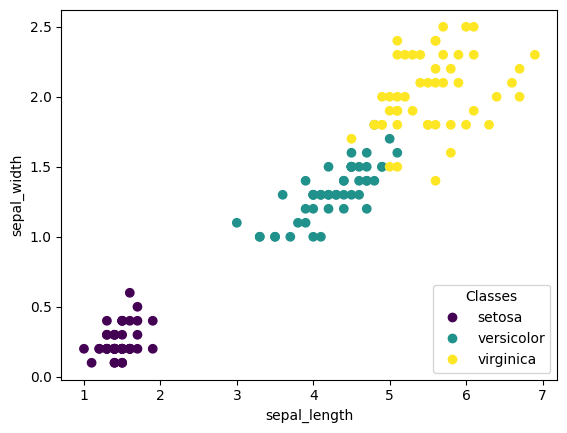

In [16]:
from sklearn import datasets

iris   = datasets.load_iris()
X_iris = iris.data[:, 2:]  # seulement les deux derniers attributs
Y_iris = iris.target

scatter = plt.scatter(X_iris[:, 0], X_iris[:, 1], c=Y_iris)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")
plt.show()

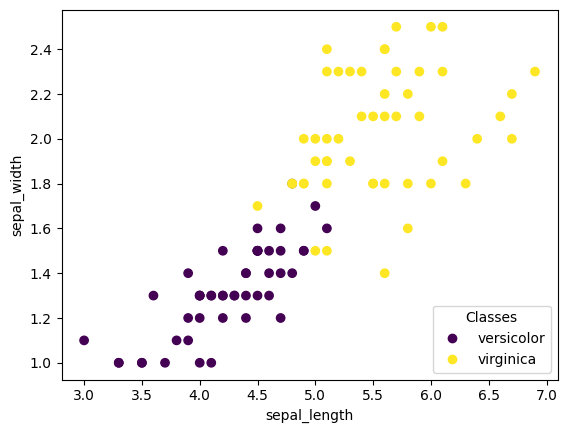

In [17]:
# supprimer les 50 premiers échantillons de "setosa"
X_irisBin = np.array(X_iris[51:, :])  # on prend les deux derniers attributs
Y_irisBin = np.array(Y_iris[51:])

# Les classes restantes ont les labels: "1" et "2"
# On les transforme à "0" et "1"
msk             = Y_irisBin == 1
Y_irisBin[ msk] = 0
Y_irisBin[~msk] = 1

scatter = plt.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend(scatter.legend_elements()[0], iris.target_names[1:], loc="lower right", title="Classes")
plt.show()


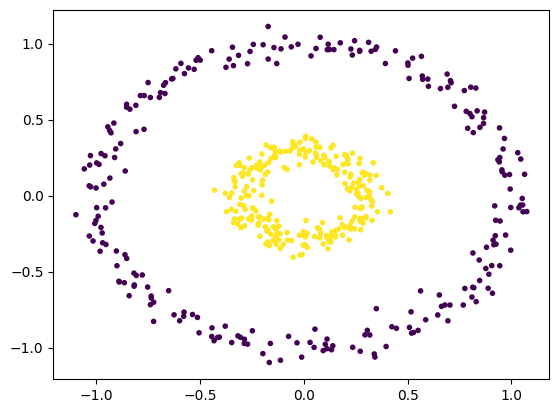

In [18]:
from sklearn.datasets import make_circles 
  
# generating data 
X_circle, Y_circle = make_circles(n_samples = 500, noise = 0.05, factor=0.3) 
  
# visualizing data 
plt.scatter(X_circle[:, 0], X_circle[:, 1], c = Y_circle, marker = '.') 
plt.show()

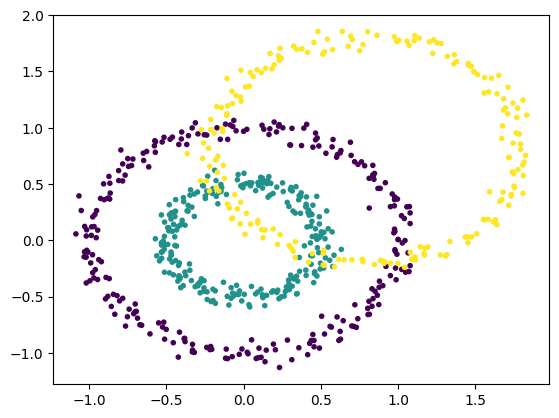

In [19]:
from sklearn.datasets import make_circles 
  
# generating data 
X_circle2, Y_circle2 = make_circles(n_samples = 500     , noise = 0.05, factor=0.5)
X_circle3, Y_circle3 = make_circles(n_samples = (200, 0), noise = 0.05, factor=0.2)

X_circle2 = np.concatenate((X_circle2, X_circle3 + 0.8), axis=0)
Y_circle2 = np.concatenate((Y_circle2, Y_circle3 + 2.0), axis=0)

# visualizing data 
plt.scatter(X_circle2[:, 0], X_circle2[:, 1], c = Y_circle2, marker = '.') 
plt.show()

### II.1. Comparison entre les méthodes d'optimisation (cas primal)

Nous voulons comparer entre GD et SGD en terme de convergence des coûts et de temps d'entraînement. 
Pour ce faire, nous allons comparer entre ces méthodes : 
- GD : La descente des sous-gradients 
- SGD : La descente stochastique des sous-gradients
- SGDA : La descente stochastique des sous-gradients (avec prise en charge de tous les échantillons par itération)


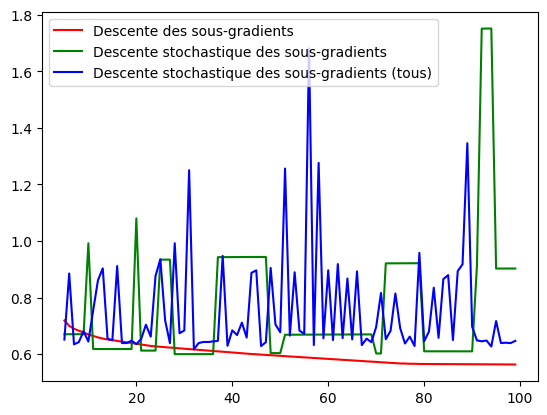

In [20]:
import timeit

NBR_IT = 100
ALPHA  = 0.1
C      = 10.
D_IT   = 5
Its    = range(D_IT, NBR_IT)
# Augmentation de la taille du dataset
# ça ne va pas affecter le résultat en terme de convergence
# c'est juste pour tester le cas avec plusieurs échantillons 
# le temps d'exécution de la fonction "random" dans "SGD" sera négligeable
X, Y = np.repeat(X_irisBin, 5, axis=0), np.repeat(Y_irisBin, 5, axis=0)

svm_gd      = SVM(max_iter=NBR_IT, alpha=ALPHA, C=C)
temps_debut = timeit.default_timer()
couts_gd    = svm_gd.entrainer(X, Y)
temps_gd    = timeit.default_timer() - temps_debut

svm_sgd     = SVM(max_iter=NBR_IT, alpha=ALPHA, C=C, solver="SGD")
temps_debut = timeit.default_timer()
couts_sgd   = svm_sgd.entrainer(X, Y)
temps_sgd   = timeit.default_timer() - temps_debut

svm_sgda    = SVM(max_iter=NBR_IT, alpha=ALPHA, C=C, solver="SGDA")
temps_debut = timeit.default_timer()
couts_sgda  = svm_sgda.entrainer(X, Y)
temps_sgda  = timeit.default_timer() - temps_debut



plt.plot(Its, couts_gd  [D_IT:], color="red"  , label="Descente des sous-gradients")
plt.plot(Its, couts_sgd [D_IT:], color="green", label="Descente stochastique des sous-gradients")
plt.plot(Its, couts_sgda[D_IT:], color="blue" , label="Descente stochastique des sous-gradients (tous)")
plt.legend()
plt.show()

In [21]:
pd.DataFrame({
    "Critere" : ["Temps Entrainement"],
    "GD"      : [temps_gd            ],
    "SGD"     : [temps_sgd           ],
    "SGDA"    : [temps_sgda          ],
})

,Critere,GD,SGD,SGDA
0,Temps Entrainement,0.141011,0.0401,0.903618


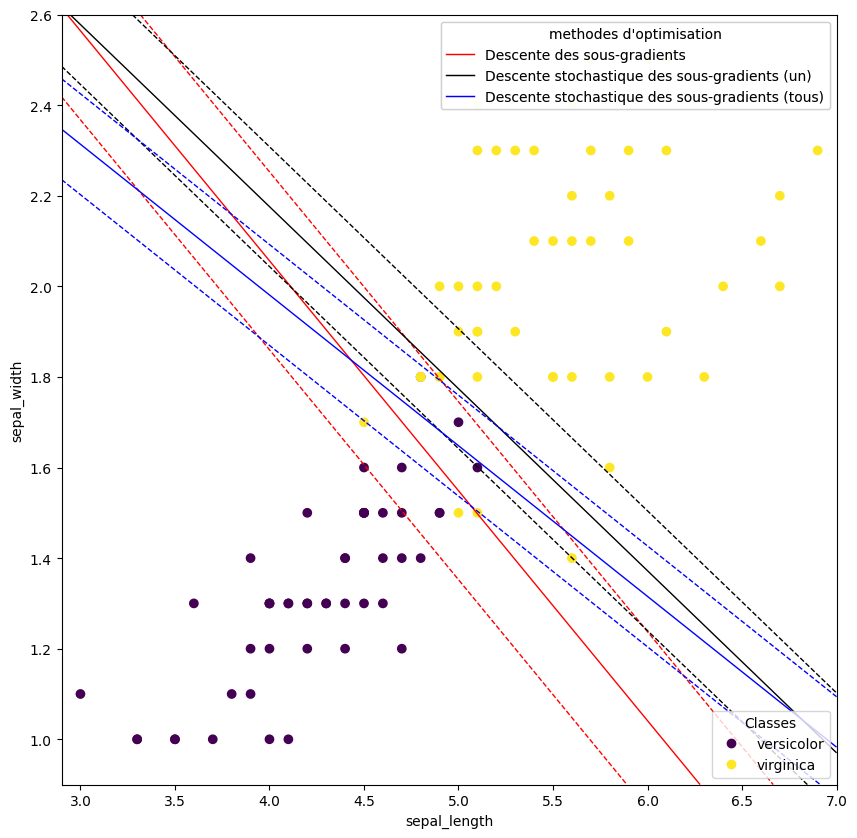

In [22]:
def dessigner(modele, ax, xx, xy, color="r", label=""):
    
    # créer une grille avec des estimations sur xx et xy
    grid = [[modele.predire(np.array([[xr, yr]]), cls=False) for xr in xx] for yr in xy]
    # transformer cette grille comme matrice
    grid = np.array(grid).reshape(len(xx), len(xy))
        
    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xx, xy, grid, levels=[-1,0,1], linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=color)
    return Line2D([0, 1], [0, 0], linewidth=1, linestyle='-', color=color)
    

fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
legend1 = plt.legend(scatter.legend_elements()[0], iris.target_names[1:], loc="lower right", title="Classes")


# generer 100 points entre le min et le max de l'attribut X[0]
xx = np.linspace(X_irisBin[:,0].min() - .1, X_irisBin[:,0].max() + .1, 100)
# generer 100 points entre le min et le max de l'attribut X[1]
xy = np.linspace(X_irisBin[:,1].min() - .1, X_irisBin[:,1].max() + .1, 100)

mthds = []
mthds.append(dessigner(svm_gd  , ax, xx, xy, color="red"  ))
mthds.append(dessigner(svm_sgd , ax, xx, xy, color="black"))
mthds.append(dessigner(svm_sgda, ax, xx, xy, color="blue" ))

mthds_lbl = [
    "Descente des sous-gradients",
    "Descente stochastique des sous-gradients (un)",
    "Descente stochastique des sous-gradients (tous)"
]
legend2 = plt.legend(mthds, mthds_lbl, loc="upper right", title="methodes d'optimisation")
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.show()

**TODO: Analyser les résultats**
- Nous remarquons que le graphe de J_GD est lisse contrairement aux deux autres. Pourquoi ?
- Est-ce que la SGD montre un avantage lorsqu'il y a des optimums locaux ? Comment ?
- Comment pouvons-nous rendre le graphe du SGD plus lisse (sans changement de l'algorithme) ? (il y a 3 paramètres à modifier)
- Nous remarquons que le temps d'entraînement est de l'ordre : t_SGD < t_GD << t_SGDA. Pouquoi ?
- Nous remarquons que le graphe de séparation linéaire du SGD est proche de celui de GD. Est-ce qu'en augmentant le nombre des itérations seulement, SGD va converger ou nous avons besoin d'autres configurations ? Préciser.

**Réponse**
- Le graphe de J_GD est lisse car la méthode de descente de gradient standard calcule la moyenne des gradients de toutes les données d'entraînement pour chaque itération. Cela signifie qu'à chaque itération, le modèle est ajusté à tous les points de données, ce qui réduit le bruit et rend la fonction de coût plus lisse. En revanche, la descente de gradient stochastique (SGD) et la descente de gradient stochastique avec moyenne (SGDA) utilisent un seul exemple ou un sous-ensemble d'exemples pour calculer les gradients à chaque itération, ce qui peut entraîner des fluctuations plus importantes dans les valeurs de la fonction de coût.

- Oui, la SGD peut montrer un avantage lorsqu'il y a des optimums locaux. Cela est dû au fait que la SGD est plus susceptible de "sauter" des minimums locaux en raison de sa nature stochastique, ce qui lui permet de chercher des chemins plus exploratoires dans l'espace de recherche. En revanche, le GD peut être piégé dans un minimum local en raison de sa nature déterministe.

    Cependant, il est important de noter que cela dépend du problème spécifique et de la nature des données. Dans certains cas, les optimums locaux peuvent ne pas être un problème pour GD, car il peut converger vers un minimum global malgré cela. En outre, la convergence vers un minimum global peut être plus lente avec SGD que GD, car la nature stochastique de SGD peut également causer plus de bruit dans la descente de gradient.

- Pour rendre le graphe du SGD plus lisse sans modifier l'algorithme lui-même, nous pouvons jouer sur les paramètres suivants :

    * **Le taux d'apprentissage (learning rate) :** Un taux d'apprentissage élevé peut conduire à une oscillation plus importante des paramètres du modèle et donc à des coûts qui fluctuent plus fortement. En diminuant le taux d'apprentissage, les mises à jour des paramètres sont moins importantes et les fluctuations du coût sont réduites.

    * **La taille de lot (batch size) :** La taille de lot détermine le nombre d'exemples d'entraînement sur lesquels le gradient est calculé. En augmentant la taille de lot, les mises à jour des paramètres sont plus stables car elles sont basées sur un plus grand nombre d'exemples. Cela peut réduire les fluctuations du coût.

    * **Le nombre d'itérations (nombre d'époques) :** Le nombre d'itérations ou le nombre d'époques détermine le nombre de fois que le modèle est entraîné sur l'ensemble des données d'entraînement. En augmentant le nombre d'époques, le modèle est plus entraîné et les fluctuations du coût peuvent être réduites.

    En ajustant ces trois paramètres, nous pouvons rendre le graphe du SGD plus lisse. Par exemple, en diminuant le taux d'apprentissage et en augmentant la taille de lot et le nombre d'époques, nous pouvons obtenir des mises à jour de paramètres plus stables et donc des coûts qui fluctuent moins fortement. Cependant, cela peut également entraîner une augmentation du temps d'entraînement. Il convient donc de trouver un compromis entre la stabilité de l'optimisation et le temps d'entraînement nécessaire.


- Le temps d'entraînement est influencé par le nombre d'itérations nécessaires pour converger vers une solution acceptable. En général, plus l'algorithme converge rapidement, moins il faut de temps d'entraînement.

    La méthode de descente de sous-gradient classique (GD) calcule le gradient sur l'ensemble des données à chaque itération, ce qui peut être très coûteux, en particulier pour des ensembles de données volumineux. En revanche, la méthode de descente de sous-gradient stochastique (SGD) ne calcule le gradient que sur un seul exemple à chaque itération, ce qui réduit considérablement le coût de calcul. Cela peut conduire à une convergence plus rapide pour des ensembles de données de grande taille, et explique pourquoi t_SGD < t_GD.

    Cependant, SGD peut être plus susceptible de converger vers un minimum local, car il est plus influencé par la variabilité due à l'échantillonnage stochastique. En revanche, la méthode de descente de sous-gradient stochastique avec prise en charge de tous les échantillons par itération (SGDA) peut réduire la variabilité en utilisant tous les échantillons à chaque itération. Cependant, cela nécessite de calculer le gradient sur l'ensemble des données à chaque itération, ce qui peut être très coûteux en termes de temps de calcul et explique pourquoi t_GD << t_SGDA.

- En augmentant le nombre d'itérations seulement, la méthode SGD peut converger vers une solution, mais cela dépend de plusieurs facteurs tels que :

    * **La taille du jeu de données :** Pour les grands ensembles de données, SGD peut avoir besoin de plus d'itérations pour converger.
    * **La densité des données :** Si les données sont dispersées, SGD peut avoir besoin de plus d'itérations pour converger car il a moins d'informations par itération.
    * **Le taux d'apprentissage (learning rate) :** un taux d'apprentissage trop petit peut causer une convergence lente tandis qu'un taux d'apprentissage trop grand peut causer une divergence.

    Dans tous les cas, augmenter le nombre d'itérations de SGD peut aider à améliorer la convergence, mais cela peut prendre plus de temps d'entraînement que GD.

### II.2. Comparison entre les formes "primal" et "dual"

Dans cette expérimentation, nous voulons comparer les deux formes "primal" et "dual" dans le contexte de la classification binaire.
Les critères utilisés pour cette comparaison sont : 
- Temps d'entraînement 
- Temps de prédiction
- Taille du modèle 

In [23]:
import sys
from sklearn.metrics import accuracy_score

# calculer la taille d'un objet avec ces composants
# code pris de ce lien
# https://stackoverflow.com/a/40880923/2296914
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size


ALPHA = 0.1
C     = 10.

# Augmentation de la taille du dataset
# ça ne va pas affecter le résultat en terme de convergence
# c'est juste pour tester le cas avec plusieurs échantillons 
# le temps d'exécution de la fonction "random" dans "SGD" sera négligeable
X, Y = np.repeat(X_irisBin, 5, axis=0), np.repeat(Y_irisBin, 5, axis=0)

primal_stats = []
dual_stats   = []

#=========== PRIMAL =======================
svm_primal  = SVM(max_iter=10, alpha=ALPHA, C=C)
temps_debut = timeit.default_timer()
svm_primal.entrainer(X, Y)
primal_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
temps_debut = timeit.default_timer()
Y_primal    = svm_primal.predire(X)
primal_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
primal_stats.append(get_size(svm_primal))
#-------------------------------------------
#primal_stats.append(accuracy_score(Y, Y_primal))

#=========== DUAL =======================
svm_dual    = DSVM(C=C, tol = 0.001)
temps_debut = timeit.default_timer()
svm_dual.entrainer(X, Y)
dual_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
temps_debut = timeit.default_timer()
Y_dual      = svm_dual.predire(X)
dual_stats.append(timeit.default_timer() - temps_debut)
#-------------------------------------------
dual_stats.append(get_size(svm_dual))
#-------------------------------------------
#dual_stats.append(accuracy_score(Y, Y_dual))

pd.DataFrame({
    "Critere" : ["Temps Entrainement", "Temps Prediction", "Taille"], #, "Accurracy entrainement"
    "Primal"  : primal_stats,
    "Dual"    : dual_stats,
})

**TODO: Analyser les résultats**
- Nous remarquons que le temps d'entraînement t_primal << t_dual. Pourquoi ? ( à part que le nombre de critère est insuffisant)
- Même remarque et question pour le temps de prédiction.
- Nous remarquons que la taille des modèles S_primal << S_dual. Pourquoi (détailler)?
- Il parait que la forme "dual" est mauvaise en se basant sur ces critères, dans ce cas, pourquoi elle est utilisée ? (donner un cas où dual est utilisée)

**Réponse**
- La différence de temps d'entraînement s'explique par la différence dans la complexité des algorithmes. En effet, la forme "primal" est un algorithme basé sur la descente de gradient, qui a une complexité de O(nd) (n : nombre d'échantillons, d : dimension des données), tandis que la forme "dual" est basée sur l'optimisation de la dualité de Lagrange, qui a une complexité de O(n^3) dans le pire des cas. Ainsi, pour des ensembles de données suffisamment grands, la forme "primal" peut être beaucoup plus rapide que la forme "dual".

- Nous remarquons également que le temps de prédiction t_primal << t_dual. Cette différence est principalement due à la complexité algorithmique de chaque forme. La forme "primal" implique une matrice de taille (nombre d'échantillons x nombre de critères) qui est généralement grande dans le cas de grands ensembles de données. Cela rend l'entraînement plus lent que la forme "dual", qui implique une matrice de taille (nombre d'échantillons x nombre d'échantillons), qui est généralement plus petite que la matrice "primal" dans le cas de grands ensembles de données. En revanche, la forme "dual" nécessite plus de temps de calcul pour la prédiction car elle nécessite de calculer le produit scalaire entre les vecteurs de support et les échantillons de test

- Le modèle de SVM en forme primaire est défini par un vecteur de poids w de taille (n_features). Dans le cas de l'entraînement primaire, nous avons entraîné SVM avec un échantillon de données d'entraînement de taille (n_samples, n_features). Ainsi, la taille totale du modèle est de (n_features).

    D'un autre côté, la forme duale nécessite de stocker deux matrices, K (matrice de Gram) et alpha (vecteur multiplicateur de Lagrange), où K a une taille de (n_samples, n_samples) et alpha a une taille de (n_samples). Ainsi, la taille totale du modèle en forme duale est de (n_samples, n_samples + n_samples), qui est généralement plus grande que la taille du modèle en forme primaire (n_features).

    Par conséquent, nous pouvons conclure que la taille du modèle en forme primaire est généralement plus petite que celle en forme duale.

- Même si la forme "dual" peut être plus coûteuse en termes de temps de calcul et de mémoire, elle peut être préférable dans certaines situations, notamment lorsque le nombre de caractéristiques est très grand et que la plupart d'entre elles sont nulles pour la plupart des échantillons. Dans ce cas, la résolution du problème primal pourrait être coûteuse car elle implique de travailler avec un grand nombre de zéros.

    Cependant, en utilisant la forme "dual", le problème peut être reformulé de telle sorte que le nombre de variables optimales est égal au nombre d'échantillons, ce qui peut être beaucoup plus petit que le nombre total de caractéristiques. Ainsi, en utilisant la forme "dual", il est possible d'économiser considérablement le temps et la mémoire nécessaires pour résoudre le problème d'optimisation.

    Par conséquent, la forme "dual" est souvent utilisée pour les problèmes de **classification binaire à grande échelle avec un grand nombre de caractéristiques, tels que la classification d'images ou la classification de documents textuels.**    

### II.3. Effet du paramètre C 

Pour tester l'effet du hyper-paramètre C, on va utiliser **sklearn.svm.SVC** qui se base sur **LIBSVC** (SMO: Sequential minimal optimization). Nous avons remarqué que le temps d'exécution n'est pas stable à chaque exécution. Donc, l'idée pour régler ça est d'exécuter la même expérimentation sur plusieurs essais (trials) et essayer de garder la moyenne des temps. 

Donc, pour tester l'effet du paramètre C, nous avons déssiné 2 schémas : 
- Les marges de pédiction pour quelques valeurs de C (sur Iris binaire, pour mieux visualiser la séparation)
- Le temps d'entrainement par rapport aux valeurs de C (sur Iris 3 classes, pour avoir plus de données)

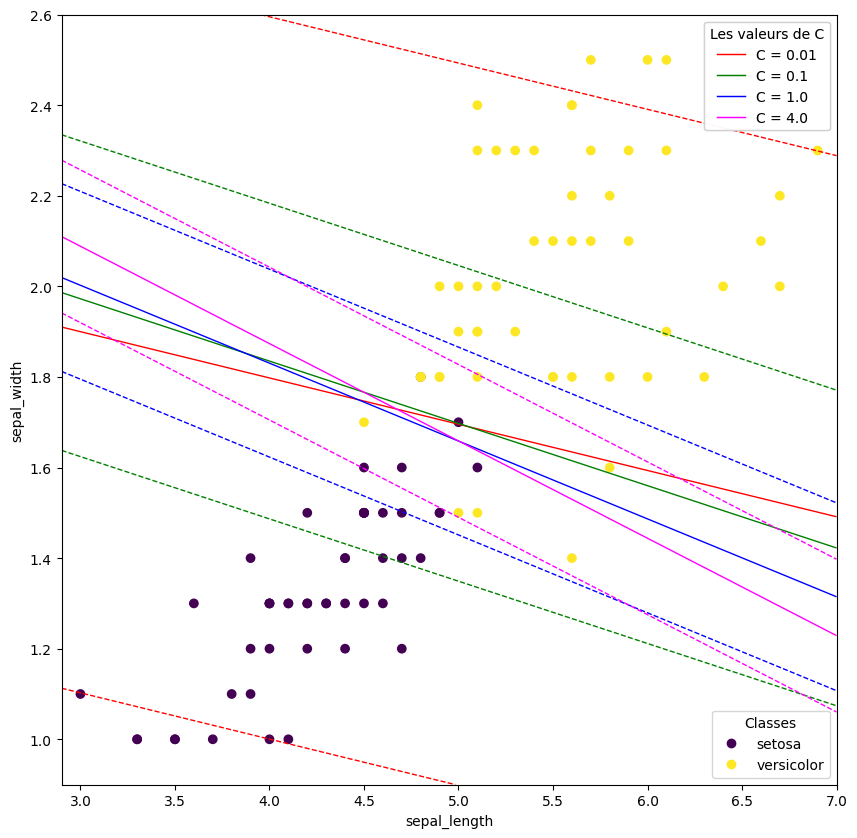

In [ ]:
from sklearn.svm import SVC

def dessigner_sklearn0(modele, ax, xx, xy, color="r", label=""):
    
    Z    = modele.decision_function(np.array(np.meshgrid(xx, xy)).T.reshape(-1, 2))
    grid = np.array(Z).reshape(len(xx), len(xy))
        
    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xx, xy, grid, levels=[-1,0,1], linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=color)
    return Line2D([0, 1], [0, 0], linewidth=1, linestyle='-', color=color)
    
fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
legend1 = plt.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

# generer 100 points entre le min et le max de l'attribut X[0]
xx = np.linspace(X_irisBin[:,0].min() - .1, X_irisBin[:,0].max() + .1, 100)
# generer 100 points entre le min et le max de l'attribut X[1]
xy = np.linspace(X_irisBin[:,1].min() - .1, X_irisBin[:,1].max() + .1, 100)

Csp       = [0.01, 0.1, 1., 4.]
mthds     = []
mthds_lbl = []
Couleurs  = ["red", "green", "blue", "magenta"]

for Cp, couleur in zip(Csp, Couleurs):
    modele = SVC(C=Cp, kernel="linear", random_state=0, probability=True)
    modele.fit(X_irisBin, Y_irisBin)
    a = dessigner_sklearn0(modele, ax, xx, xy, color=couleur)
    mthds.append(a)
    mthds_lbl.append("C = " + str(Cp))
    
legend2 = plt.legend(mthds, mthds_lbl, loc="upper right", title="Les valeurs de C")
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.show()

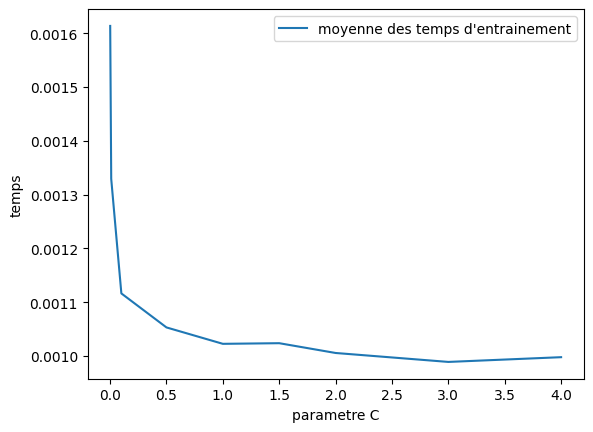

In [ ]:
# from sklearn.preprocessing import StandardScaler

TRIALS = 50

X, Y = np.repeat(X_iris, 1, axis=0), np.repeat(Y_iris, 1, axis=0)
#X, Y = X_circle2, Y_circle2

# normalisateur = StandardScaler()
# X = normalisateur.fit_transform(X)

Cs       = [0.001, 0.01, 0.1, 0.5, 1., 1.5, 2., 3, 4]
Tr_stats = []

for tr in range(TRIALS):
    Cs_stats = []
    Tr_stats.append(Cs_stats)
    for C in Cs:
        modele      = SVC(C=C, kernel="linear", random_state=0)
        temps_debut = timeit.default_timer()
        modele.fit(X, Y)
        Cs_stats.append(timeit.default_timer() - temps_debut)

# Temps_max = np.max(Tr_stats, axis=0)
# plt.plot(Cs, Temps_max, label="maximum des temps d'entrainement")
# Temps_min = np.min(Tr_stats, axis=0)
# plt.plot(Cs, Temps_min, label="minimum des temps d'entrainement")
Temps_moy = np.mean(Tr_stats, axis=0)
plt.plot(Cs, Temps_moy, label="moyenne des temps d'entrainement")
plt.xlabel("parametre C")
plt.ylabel("temps")
plt.legend()
plt.show()


**TODO: Analyser les résultats** /* A REVOIR*/
- Quelle est l'effet de la valeur C sur les marges de prédiction ?
- Nous remarquons (en général) que le temps  d'entraînement se diminue avec des valeurs grandes de **C**. Comment **C** peut affecter ce temps ?

**Réponse**
- La valeur de C est un hyperparamètre important pour SVM car elle contrôle l'équilibre entre la maximisation de la marge et la minimisation de l'erreur d'entraînement.

    Dans le premier schéma, on observe que plus la valeur de C augmente, plus la marge de prédiction devient étroite et plus les exemples mal classés sont autorisés. Cela signifie que pour des valeurs de C élevées, le modèle peut mieux s'adapter aux données d'entraînement, mais il peut aussi être plus sensible au bruit ou aux erreurs d'étiquetage.

    Dans l'ensemble, le choix de la valeur de C dépend de la complexité du problème de classification et de la qualité des données. Des valeurs de C plus élevées peuvent donner des performances meilleures sur les données d'entraînement, mais des performances moins bonnes sur les données de test ou sur de nouvelles données.
    
    Augmenter la valeur de C, implique que la marge de prédiction devient de plus en plus petite.

- Le paramètre C contrôle le compromis entre la complexité du modèle et la précision du modèle sur les données d'entraînement. Lorsque la valeur de C est élevée, le modèle est moins tolérant aux erreurs d'entraînement et tente d'optimiser la prédiction des données d'entraînement, ce qui peut conduire à une augmentation de la complexité du modèle. En général, une complexité plus élevée signifie que le temps d'entraînement peut augmenter car il y a plus de paramètres à optimiser.

    Cependant, il est important de noter que l'effet de C sur le temps d'entraînement peut varier en fonction de la taille et de la complexité du jeu de données, ainsi que de la méthode d'optimisation utilisée pour résoudre le problème d'optimisation associé au modèle SVM. 

    La valeur de C autorise certains points à se situer à l'intérieur de la marge, ce qui réduit le temps d'entraînement en arrêtant plus rapidement la recherche du séparateur.

### II.4. Choix des noyaux

Dans cette expérimentation, on veut voir l'effet du choix du noyau pour un certain problème. On va tester sur le dataset Iris multiclasses. L'analyse des résultats se fait en se basant sur :
- La séparation des modèles (visualisation)
- Le F-1 score de convergence 
- Le temps d'entrainement

Les noyaux utilisés sont : 
- **linear** : un noyau linéaire 
- **poly** : un noyau polynomial avec degrée 4 
- **rbf** : un noyau radial (Radial Basis Function)
- **cosine** : un noyau avec similarity cosinus entre les échantillons

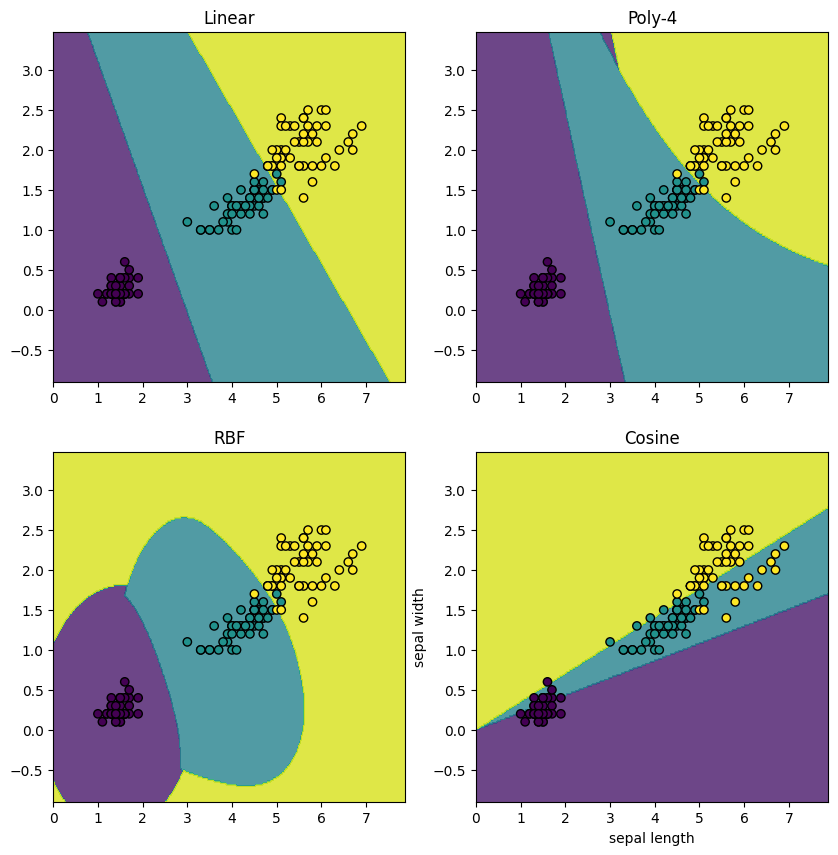

In [ ]:
# Test inspiré de https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html

def dessigner_sklearn(modele, ax, xx, xy, X, Y, label=""):
    
    Z   = modele.predict(np.c_[xx.ravel(), xy.ravel()])
    Z   = Z.reshape(xx.shape)
    out = ax.contourf(xx, xy, Z, alpha=0.8)
    
    scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k")
    plt.xlabel("sepal length")
    plt.ylabel("sepal width")
    ax.set_title(label)
    


from sklearn.metrics.pairwise import cosine_similarity

modeles = [
    SVC(kernel="linear"         , random_state=0, probability=True           ),
    SVC(kernel="poly"           , random_state=0, probability=True, degree=4 ),
    SVC(kernel="rbf"            , random_state=0, probability=True, gamma=0.7),
    SVC(kernel=cosine_similarity, random_state=0, probability=True           ),
]

labels = [
    "Linear",
    "Poly-4",
    "RBF"   ,
    "Cosine"
]

temps_kernel = []


fig, axs = plt.subplots(2, 2, figsize=(10,10))


xx_min, xx_max = X_iris[:, 0].min() - 1, X_iris[:, 0].max() + 1
xy_min, xy_max = X_iris[:, 1].min() - 1, X_iris[:, 1].max() + 1
xx, xy = np.meshgrid(np.arange(xx_min, xx_max, .02), np.arange(xy_min, xy_max, .02))

for modele, label, ax in zip(modeles, labels, axs.flatten()):
    temps_debut = timeit.default_timer()
    modele.fit(X_iris, Y_iris)
    temps_kernel.append(timeit.default_timer() - temps_debut)
    dessigner_sklearn(modele, ax, xx, xy, X_iris, Y_iris, label=label)

plt.show()

In [ ]:
from sklearn.metrics import f1_score

perf = []

for modele in modeles:
    perf.append(f1_score(Y_iris, modele.predict(X_iris), average="micro"))

pd.DataFrame({
    "Noyau"                : labels,
    "F1 entrainement"      : perf,
    "Temps d'entrainement" : temps_kernel
})

,Noyau,F1 entrainement,Temps d'entrainement
0,Linear,0.966667,0.001954
1,Poly-4,0.960000,0.002283
2,RBF,0.966667,0.002638
3,Cosine,0.780000,0.005688


**TODO: Analyser les résultats** /* A REVOIR */
- En se basant sur les lignes de décision et le F1-score, quel est le meilleur noyau pour ce problème à votre avis ?
- Pourquoi ?

**Réponse** 
- En se basant sur les lignes de décision et le F1-score, on peut conclure que le meilleur noyau pour ce problème est le noyau "linear" (aussi RBF si on voit juste el F1 entrainement sans le temps d'entrainement).
- En effet, les 4 noyaux ont produit des résultats satisfaisants en termes de classification des données, mais la visualisation montre que le noyau linéaire donne des résultats plus clairs et plus simples que les autres noyaux. De plus, le F1-score est légèrement meilleur pour le noyau linéaire avec une valeur de 0.9667 par rapport aux autres noyaux qui ont une valeur de 0.96.

### II.5. Problème et noyaux

Ici, on veut tester l'effet de la complexité du problème sur la séparation, ainsi que le paramétrage. On va utiliser le noyau **RBF** qui est plus souple et qui supporte des problèmes plus complexes (non séparables linéairement). On va utiliser deux critères dans cette expérimentation : 
- F1-score de convergence
- Séparation entre classes (visualisation)

Les problèmes traités sont : 
- **Iris** : séparation linéaire entre 3 classes 
- **Iris 2 classes** : séparation linéaire binaire
- **Cercle 2 classes** : séparation radiale binaire
- **Cercle 3 classes avec chevauchement** : séparation radiale, mais avec chevauchement entre classes (ici, configuration un peu différente pour RBF)

In [ ]:
rbf2 = SVC(kernel="rbf", random_state=0, gamma=0.7, probability=True)
rbf3 = SVC(kernel="rbf", random_state=0, gamma=0.7, probability=True)
rbf4 = SVC(kernel="rbf", random_state=0, gamma=10., probability=True)

rbf2.fit(X_irisBin, Y_irisBin)
rbf3.fit(X_circle, Y_circle)
rbf4.fit(X_circle2, Y_circle2)

perf2 = []
perf2.append(f1_score(Y_iris   , modeles[2].predict(X_iris), average="micro"))
perf2.append(f1_score(Y_irisBin, rbf2.predict(X_irisBin)   , average="micro"))
perf2.append(f1_score(Y_circle , rbf3.predict(X_circle)    , average="micro"))
perf2.append(f1_score(Y_circle2, rbf4.predict(X_circle2)   , average="micro"))

pd.DataFrame({
    "Problème"        : ["Iris", "Iris deux classes", "Cercles", "cercles 3 classes"],
    "F1 entrainement" : perf2
})

,Problème,F1 entrainement
0,Iris,0.966667
1,Iris deux classes,0.949495
2,Cercles,1.000000
3,cercles 3 classes,0.952857


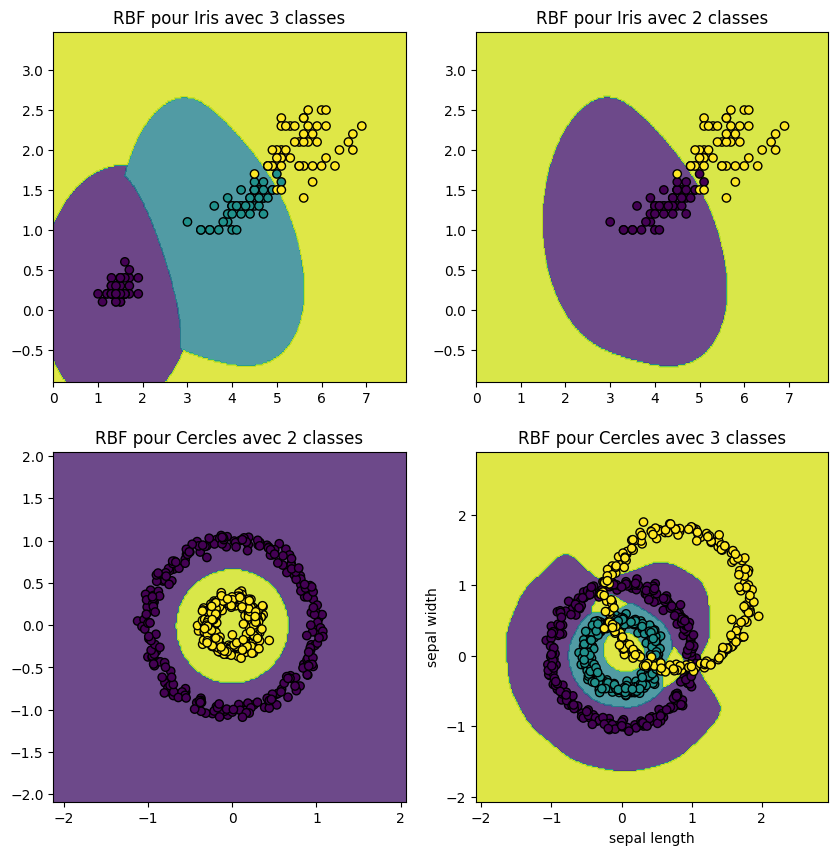

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))


dessigner_sklearn(modeles[2], ax1, xx, xy, X_iris, Y_iris, label="RBF pour Iris avec 3 classes")
dessigner_sklearn(rbf2, ax2, xx, xy, X_irisBin, Y_irisBin, label="RBF pour Iris avec 2 classes")

xx_min3, xx_max3 = X_circle[:, 0].min() - 1, X_circle[:, 0].max() + 1
xy_min3, xy_max3 = X_circle[:, 1].min() - 1, X_circle[:, 1].max() + 1
xx3, xy3 = np.meshgrid(np.arange(xx_min3, xx_max3, .02), np.arange(xy_min3, xy_max3, .02))
dessigner_sklearn(rbf3, ax3, xx3, xy3, X_circle, Y_circle, label="RBF pour Cercles avec 2 classes") 

xx_min4, xx_max4 = X_circle2[:, 0].min() - 1, X_circle2[:, 0].max() + 1
xy_min4, xy_max4 = X_circle2[:, 1].min() - 1, X_circle2[:, 1].max() + 1
xx4, xy4 = np.meshgrid(np.arange(xx_min4, xx_max4, .02), np.arange(xy_min4, xy_max4, .02))
dessigner_sklearn(rbf4, ax4, xx4, xy4, X_circle2, Y_circle2, label="RBF pour Cercles avec 3 classes")

plt.show()

**TODO: Analyser les résultats** /* A REVOIR*/
- Pourquoi le modèle converge mieux sur "Cercle 2 classes" malgré que c'est un problème plus complexe que les deux problèmes linéairement séparables ?
- Pourquoi le modèle donne un F1-score meilleur sur "Iris" que "Iris 2 classes" malgré ce dernier est un problème plus simple ? (c'est un piège)

**Réponse**
- Le modèle converge mieux sur "Cercle 2 classes" car le noyau RBF est plus adapté pour traiter les problèmes non linéairement séparables. Dans le cas des données "Cercle 2 classes", les points des deux classes sont séparés par une frontière non-linéaire, qui suit la forme des cercles. Le noyau RBF permet de créer des frontières de décision non-linéaires en créant des projections non-linéaires de l'espace des caractéristiques.

    Dans les deux autres problèmes, les classes sont linéairement séparables, c'est-à-dire que les points peuvent être séparés par une frontière linéaire. Le noyau RBF peut toujours être utilisé, mais il n'est pas nécessaire car un noyau linéaire est suffisant pour séparer les classes. 

    le noyau RBF est souvent plus approprié pour les problèmes où les données sont disposées sous forme de deux cercles, car il est capable de capturer les relations non linéaires entre les données de manière plus efficace que les méthodes linéaires. Pour les problèmes avec des classes séparables linéairement, il est souvent plus approprié d'utiliser des méthodes linéaires telles que la régression logistique ou la classification par SVM avec un noyau linéaire.

- Il peut y avoir plusieurs raisons pour expliquer pourquoi le modèle donne un F1-score meilleur sur "Iris" que "Iris 2 classes" malgré ce dernier est un problème plus simple :

    * **La simplicité d'un problème :** cela ne signifie pas nécessairement qu'il est facile à résoudre. En effet, même si "Iris 2 classes" est un problème linéairement séparable, cela ne garantit pas que la séparation soit facile pour le modèle à trouver. D'un autre côté, même si "Iris" est un problème linéairement non séparable, cela ne signifie pas que la séparation soit difficile pour le modèle à trouver. Donc, la complexité d'un problème ne correspond pas toujours à la difficulté de le résoudre.

    * **Le noyau RBF :** utilisé dans cette expérience est plus souple et peut mieux adapter aux données complexes. Cela peut expliquer pourquoi le modèle RBF donne de meilleurs résultats pour "Cercle 2 classes" malgré que c'est un problème plus complexe. Pour "Iris", le noyau RBF peut également mieux adapter aux données non linéairement séparables et donc améliorer les performances du modèle par rapport à un modèle linéaire.

    * **Le choix des hyperparamètres :** peut également affecter les performances du modèle. Dans cette expérience, les hyperparamètres des modèles sont fixés arbitrairement sans faire d'optimisation. Il est donc possible que les hyperparamètres choisis conviennent mieux à "Iris" qu'à "Iris 2 classes".

    En conclusion, la classe supplémentaire dans le problème "Iris" peut être séparée facilement, ce qui contribue à améliorer la performance du modèle et son score F1.